In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc
import pandas as pd
import seaborn as sb

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [7]:
## Define color palette
pal = sb.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
import os,sys

figdir = './'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [9]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [10]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [11]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

# Set up anndata

In [12]:
adata = sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/adata_mm_MG_fine_type_WORKING.h5ad')
adata

AnnData object with n_obs × n_vars = 52981 × 19308
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LETTER'
   

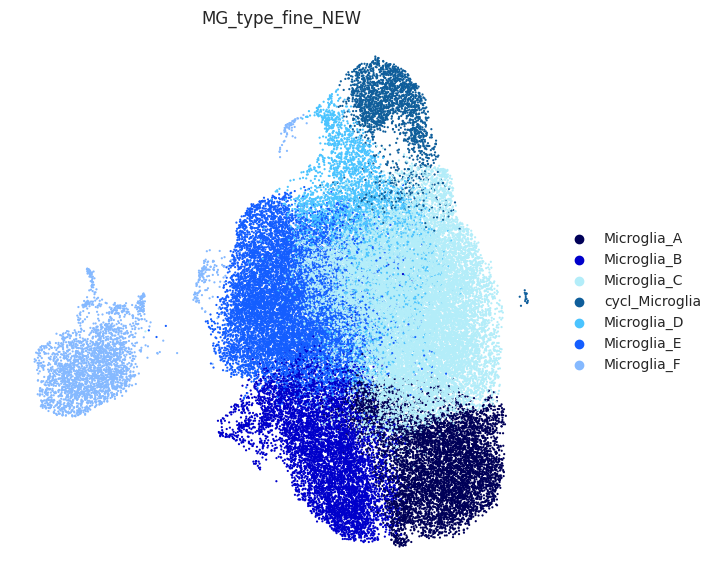

In [13]:
#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['MG_type_fine_NEW'], legend_fontsize =float(10) , wspace=0.6, 
           legend_fontweight= 'bold', frameon= False, s=10, 
           legend_fontoutline=1) #save=time+'_annotated_cell_types_NEW.pdf' )

In [14]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_type_fine_NEW'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_E
cycl_Microglia
Microglia_C
Microglia_D
Microglia_F
Microglia_A
Microglia_B


# Start MILO analysis--

In [15]:
## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 52981 × 19308
  2 modalities
    rna:	52981 x 19308
      obs:	'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LETTER'
      var:	'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'Cycling_cells_colors', 'MG_leiden_annotated_colors', 'MG_leiden_annotated_sizes', 'MG_type_fine_LETTER_colors', 'MG_type_fine_LETTER_sizes', 'MG_type_fine_NEW_NUMBERED_colors', 'MG_type_fine_NEW_colors', 'MG_type_fine_NEW_sizes', 'MG_type_fine_NUMBERED_colors', 'MG_type_fine_colors', 'MG_type_fine_reduced_colors', 'MG_type_fine_sizes', 'S_phase_cells_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_leiden_annotated_colors', 'cluster_annotation_colors', 'covariate_categ_orders', 'covariate_key_orders', 'dendrogram_MG_leiden_annotated', 'dendrogram_MG_type_fine', 'dendrogram_MG_type_fine_NEW', 'dendrogram_MG_type_fine_reduced', 'dendrogram_cell_type_eval', 'dendrogram_cluster_annotation', 'dendrogram_condition', 'dendrogram_leiden_MG_r0.3', 'dendrogram_leiden_MG_r0.5', 'dendrogram_lesion_condition', 'dendrogram_sys_leiden_1', 'hvg', 'layer_information', 'leiden', 'leiden_MG_r0.3', 'leiden_MG_r0.3_colors', 'leiden_MG_r0.3_sizes', 'leiden_MG_r0.5', 'leiden_MG_r0.5_colors', 'leiden_MG_r0.7', 'leiden_MG_r0.7_colors', 'leiden_MG_r1', 'leiden_MG_r1_colors', 'lesion_condition_colors', 'neighbors', 'paga', 'phase_colors', 'publication_colors', 'rank_genes_MG_type_fine_NEW', 'rank_genes_groups', 'rank_genes_leiden_MG_r0.3', 'rank_genes_leiden_MG_r0.5', 'rank_genes_reduced', 'sys_leiden_1_colors', 'sys_leiden_2_colors', 'sys_leiden_new_1_colors', 'sys_leiden_new_2_colors', 'system_order', 'type_fine_colors', 'umap'
      obsm:	'X_pca', 'X_sysVI', 'X_umap', 'covariates', 'system'
      layers:	'counts', 'log1p_norm', 'scaled'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [43]:
sc.pp.neighbors(mdata["rna"], use_rep="X_sysVI", n_neighbors=300)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:57)


In [44]:
milo.make_nhoods(mdata["rna"], prop=0.1)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.185634  3.6756496 3.1463242 ... 1.8544719 2.0075374 2.502783 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


In [45]:
mdata['rna'].obsm

AxisArrays with keys: X_pca, X_sysVI, X_umap, covariates, system, nhoods

In [46]:
mdata["rna"].obsm["nhoods"]

<52981x4251 sparse matrix of type '<class 'numpy.float32'>'
	with 2318862 stored elements in Compressed Sparse Row format>

In [47]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
barcode,,
TGGATGTAGGTTAGTA-1_adams,1,4.185634
CTGTGAACACTGTTCC-1_adams,1,3.675650
TTCCTCTGTATGTCAC-1_adams,1,3.146324
GTTAGACTCAACCTTT-1_adams,1,2.151174
TACTTGTAGCGGGTTA-1_adams,1,3.145792
...,...,...
GAACGGAGTCATGCAT-1_shen,1,2.327187
CATTCGCTCGTCTGCT-1-1_shen,1,1.981771
CGATCGGAGGCTAGCA-1-2_shen,1,1.854472


Text(0, 0.5, '# nhoods')

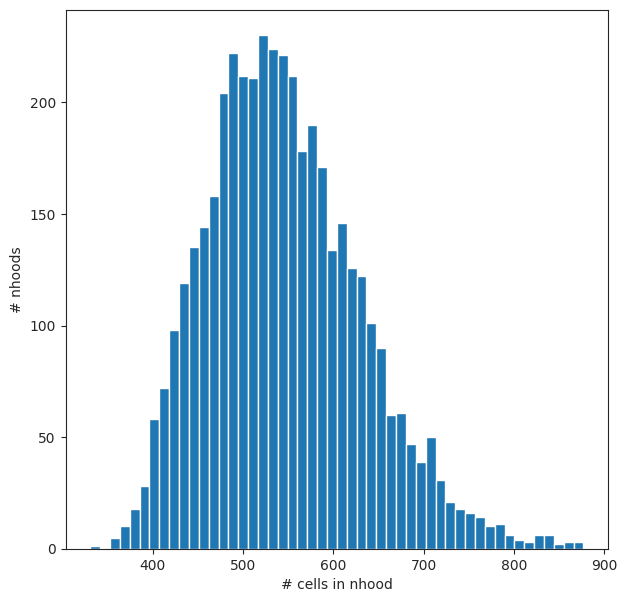

In [48]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods")

In [49]:
np.median(nhood_size)
#Want 5*number of samples 

537.0

In [50]:
mdata = milo.count_nhoods(mdata, sample_col="sample_id")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [51]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 4251
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

# Set up comparison

In [52]:
# Update the 'treatment_meta' column based on the mapping
mdata["rna"].obs['status'] = mdata["rna"].obs['lesion_status']

In [53]:
# Unique values in the 'condition' column
unique_conditions = mdata["rna"].obs["status"].unique()
for condition in unique_conditions:
    print(condition)

LPC_demyel
LPC_baseline
Cupr_demyel
Cupr_baseline
LPC_remyel
LPC_mid_remyel
Cupr_remyel


In [54]:
# Convert the 'status' column to categorical dtype first
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].astype("category")

# Now reorder the categories as you were trying to do
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].cat.reorder_categories([
    "LPC_baseline", "LPC_demyel", "LPC_mid_remyel", "LPC_remyel", "Cupr_baseline", "Cupr_demyel", "Cupr_remyel"], ordered=True)

In [55]:
milo.da_nhoods(
    mdata, design="~status", model_contrasts="statusCupr_remyel-statusCupr_baseline"
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


In [56]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 4251
    obs: 'status', 'sample_id'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR'
    uns: 'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

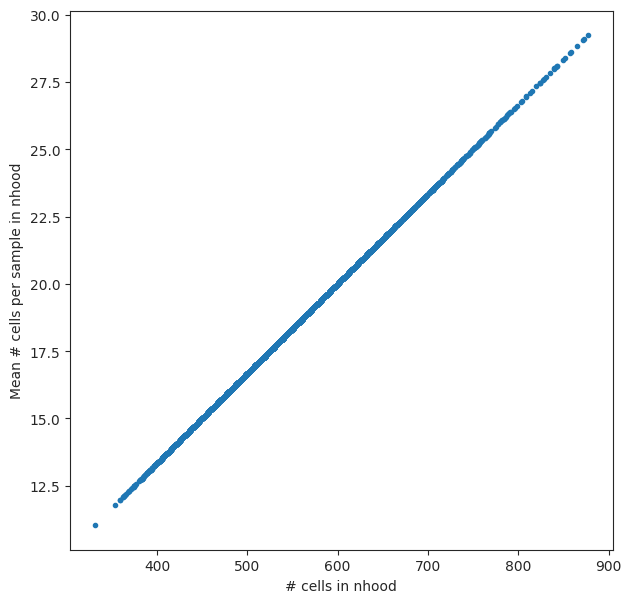

In [57]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

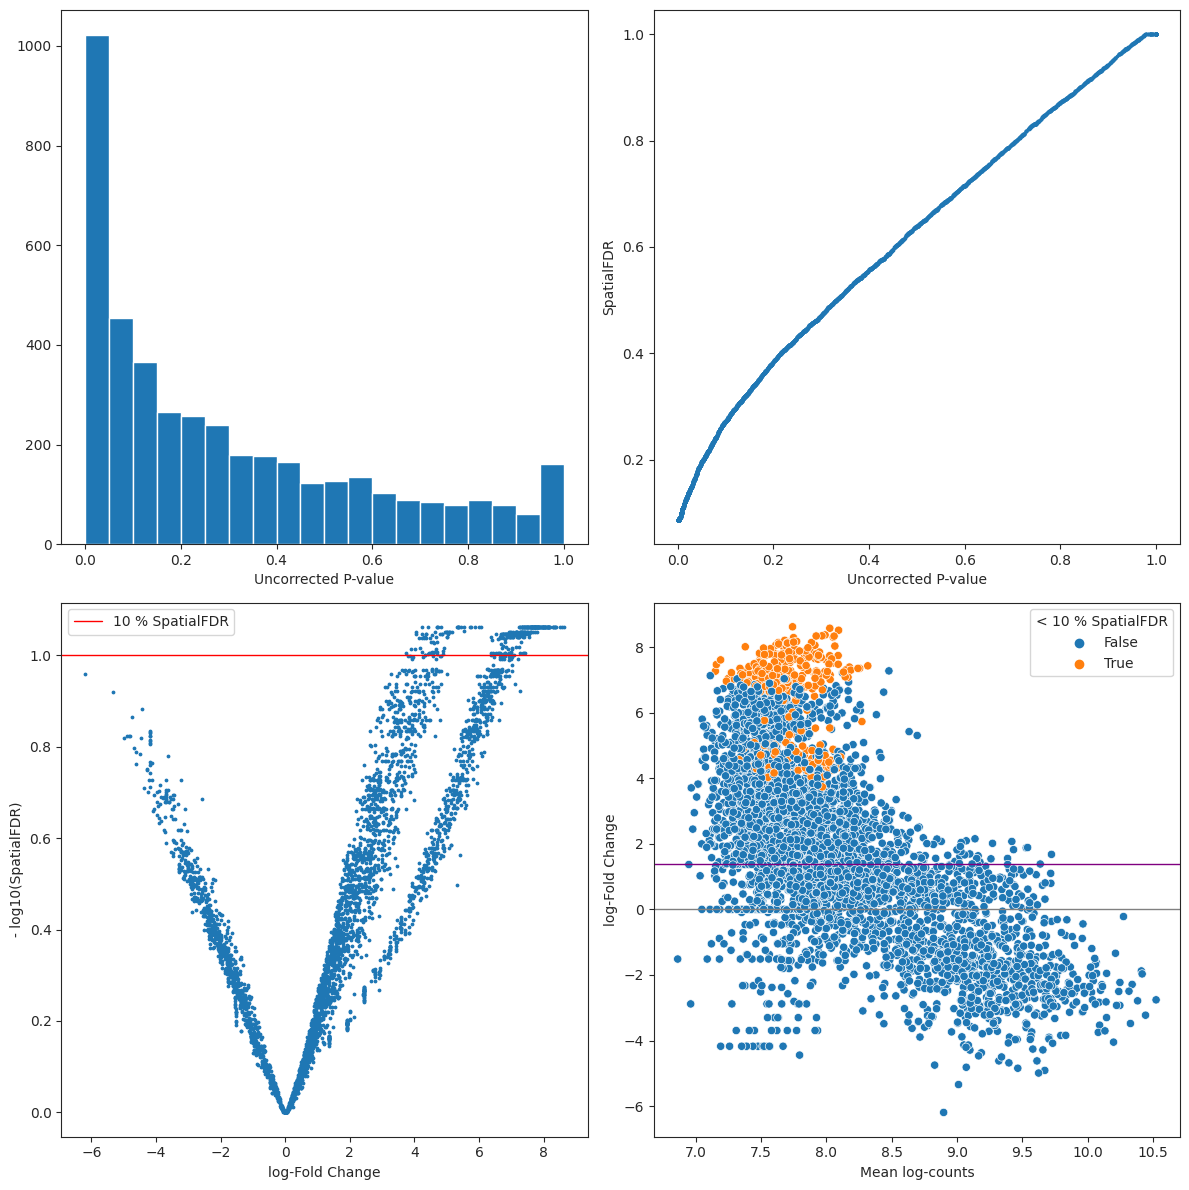

In [58]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sb.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

# Visualize results on embedding

In [59]:
milo.build_nhood_graph(mdata)

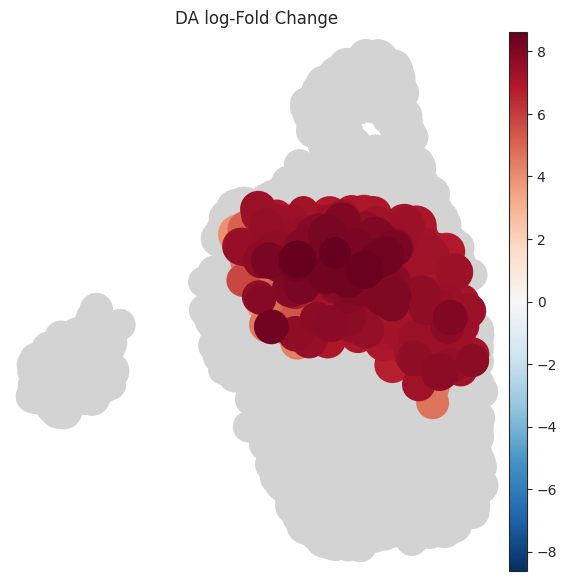

In [60]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (0.1%)
    min_size=5,  ## Size of smallest dot
    plot_edges=False,
)

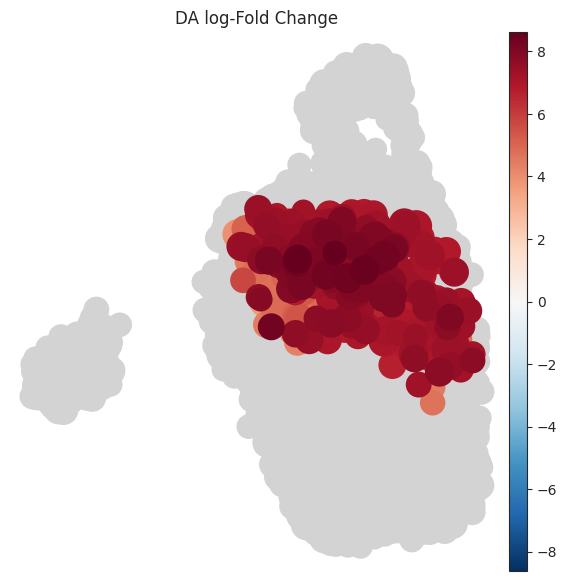

In [61]:
# Prepend the folder to the save filename
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  # SpatialFDR level (0.1%)
    min_size=3,  # Size of smallest dot
    plot_edges=False,
    save="_Cupr_remyel_MG_all.png"
)

# Visualize by cell type

In [62]:
milo.annotate_nhoods(mdata, anno_col="MG_type_fine_NEW")

Text(0.5, 0, 'celltype fraction')

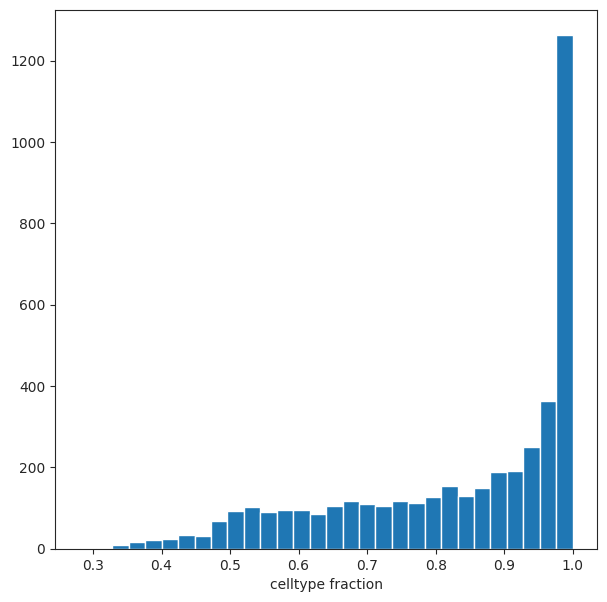

In [63]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [64]:
# Check current categories of 'nhood_annotation'
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories

# Add new category 'Mixed' if it doesn't already exist
if "Mixed" not in current_categories:
    mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")

# Now assign "Mixed" to rows where 'nhood_annotation_frac' < 0.6
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:908: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is 

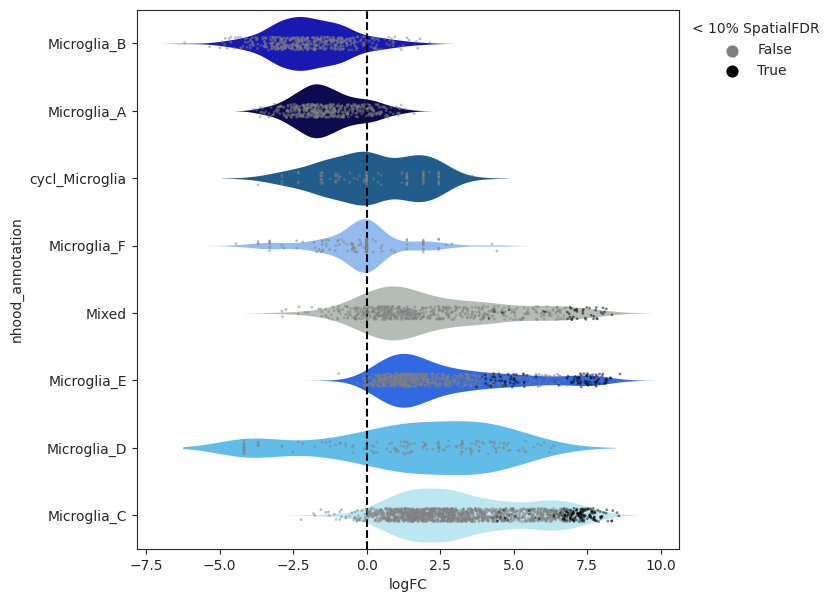

In [65]:
cluster_color = {     
    'cycl_Microglia': '#0f5e9b',  
    'Microglia_A': '#000058',    
    'Microglia_B': '#0000cb',
    'Microglia_C': '#b3edf9',
    'Microglia_D': '#4bc4ff',  
    'Microglia_E': '#145eff', 
    'Microglia_F': '#85b9ff', 
    'Mixed': '#b2beb5'
}

# Ensure all categories including 'Mixed' are in the nhood_annotation
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories
desired_categories = list(cluster_color.keys())

for cat in desired_categories:
    if cat not in current_categories:
        mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories(cat)

# Now plot with custom colors
milo.plot_da_beeswarm(mdata, alpha=0.1, 
                      palette=cluster_color,
                     save='_Cupr_remyel_MG_ALL.png')

# Alternate beeswarm

In [66]:
nh_df = mdata["milo"].var.copy()
nh_df

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Sig,Nhood_size,nhood_annotation,nhood_annotation_frac
0,TGGATGTAGGTTAGTA-1_adams,4.185634,-2.883517,7.659003,2.231713,0.138099,0.334362,0.316602,False,472.0,cycl_Microglia,1.000000
1,CTGTGAACACTGTTCC-1_adams,3.675650,-0.435435,7.680012,0.060766,0.805737,0.884148,0.875582,False,483.0,cycl_Microglia,0.933747
2,TTCCTCTGTATGTCAC-1_adams,3.146324,3.493789,8.158680,3.089890,0.081244,0.258896,0.243712,False,487.0,Microglia_E,0.979466
3,GTTAGACTCAACCTTT-1_adams,2.151174,-2.266084,9.561690,1.596206,0.208760,0.413725,0.393626,False,585.0,Microglia_A,0.993162
4,TACTTGTAGCGGGTTA-1_adams,3.145792,-1.560017,8.143335,0.597314,0.441269,0.603162,0.586941,False,873.0,cycl_Microglia,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4246,GAACGGAGTCATGCAT-1_shen,2.327187,-2.495130,10.316207,1.644195,0.202180,0.406944,0.387086,False,484.0,Microglia_B,0.995868
4247,CATTCGCTCGTCTGCT-1-1_shen,1.981771,-3.480392,10.327268,2.774052,0.098365,0.286993,0.270302,False,722.0,Microglia_B,0.994460
4248,CGATCGGAGGCTAGCA-1-2_shen,1.854472,-2.779991,9.374471,1.962401,0.163657,0.361782,0.343373,False,632.0,Microglia_B,1.000000
4249,TTAGTTCTCTGAGGGA-1_shen,2.007537,-3.036398,9.546057,2.272978,0.134114,0.329060,0.311242,False,651.0,Microglia_B,0.993856


Text(0, 0.5, '- log10(Spatial FDR)')

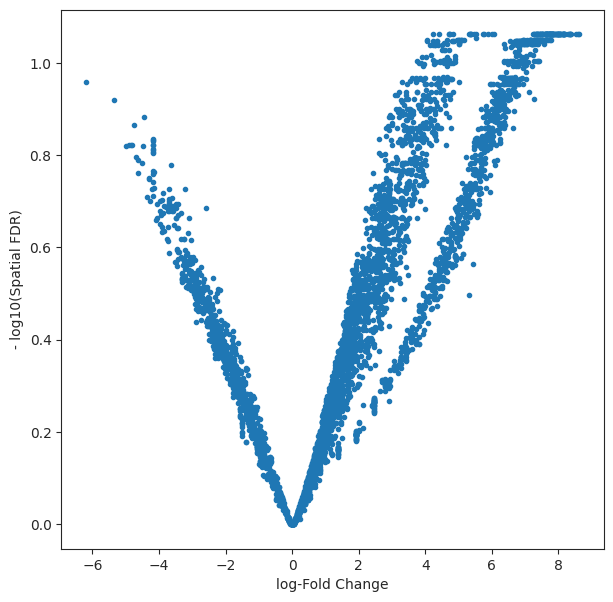

In [67]:
plt.plot(nh_df.logFC, -np.log10(nh_df.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

In [68]:
%%R -i nh_df
head(nh_df)

                index_cell kth_distance      logFC   logCPM          F
0 TGGATGTAGGTTAGTA-1_adams     4.185634 -2.8835167 7.659003 2.23171338
1 CTGTGAACACTGTTCC-1_adams     3.675650 -0.4354347 7.680012 0.06076635
2 TTCCTCTGTATGTCAC-1_adams     3.146324  3.4937886 8.158680 3.08988986
3 GTTAGACTCAACCTTT-1_adams     2.151174 -2.2660837 9.561690 1.59620605
4 TACTTGTAGCGGGTTA-1_adams     3.145792 -1.5600168 8.143335 0.59731419
5 GTCCTCAAGACGCCAA-1_adams     2.878739 -0.9290544 8.622492 0.31386265
      PValue       FDR SpatialFDR   Sig Nhood_size nhood_annotation
0 0.13809882 0.3343624  0.3166021 FALSE        472   cycl_Microglia
1 0.80573735 0.8841480  0.8755820 FALSE        483   cycl_Microglia
2 0.08124372 0.2588959  0.2437117 FALSE        487      Microglia_E
3 0.20876025 0.4137249  0.3936257 FALSE        585      Microglia_A
4 0.44126871 0.6031618  0.5869414 FALSE        873   cycl_Microglia
5 0.57631411 0.7103251  0.6977996 FALSE        427      Microglia_A
  nhood_annotation_frac
0  

In [69]:
nh_df.to_csv('./MG_figures/nh_df_Cupr_remyel_NEW_KEEP_ALL.csv', index=True)  # index=True to include row names

In [ ]:
%%R -h 700 -w 600

#figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 0.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width = 10, height = 12)

In [ ]:
%%R -h 700 -w 600

figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +  # Increase the size here
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno2.pdf'), width = 10, height = 12)

# Display the plot
print(last_plot())

# Visualize by cell counts

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "OPCs")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MFOLs")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL2_DAO1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL2")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL3")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL4")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

In [ ]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "MOL4_DAO1")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="status", subset_nhoods=pl_nhoods, log_counts=False)

# Setting gene expression on DA testing by status

In [ ]:
## Compute average Retnlb expression per neighbourhood
# (you can add mean expression for all genes using milo.utils.add_nhood_expression)
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "Serpina3n"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")
# milo.annotate_nhoods(mdata, "Retnlb_expression")

## Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression")
plt.show()

In [ ]:
## Compute average Retnlb expression per neighbourhood
# (you can add mean expression for all genes using milo.utils.add_nhood_expression)
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "C4b"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")
# milo.annotate_nhoods(mdata, "Retnlb_expression")

## Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression")
plt.show()

In [ ]:
# Compute average Retnlb expression per neighbourhood
mdata["rna"].obs["DAO_expression"] = (
    mdata["rna"][:, "Serpina3n"].layers["log1p_norm"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "DAO_expression")

# Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "MOL2_DAO1"]

In [ ]:
nhood_df[:5]

In [ ]:
# Get status for each neighbourhood based on 'index_cell'
nhood_statuses = mdata["rna"].obs.loc[nhood_df.index_cell, "status"].reset_index()
nhood_statuses.columns = ['barcode', 'status']
nhood_statuses[:5]

In [ ]:
# Create a mapping dictionary from nhood_statuses
status_mapping = nhood_statuses.set_index('barcode')['status'].to_dict()

# Map 'status' from nhood_statuses to nhood_df using 'index_cell'
nhood_df['status'] = nhood_df['index_cell'].map(status_mapping)

# Display the updated nhood_df with 'status' column added
nhood_df[:5]

In [ ]:
# Define status to color mapping
status_colors = {
    'control': '#0033ff',
    'LPC_early': '#cc0000',
    'LPC_mid': '#cc6699',
    'LPC_late': '#ffccff',
}

# Map statuses to colors
nhood_df['status_color'] = nhood_df['status'].map(status_colors)
nhood_df[:5]

In [ ]:
# Plot the scatterplot with manual colors
plt.figure(figsize=(8, 6))
sb.scatterplot(data=nhood_df, x="logFC", y="nhood_DAO_expression", c=nhood_df["status_color"], s=50)
plt.xlabel("logFC")
plt.ylabel("nhood_DAO_expression")
plt.title("Scatterplot with 'status' colors")

# Manually create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=status) for status, color in status_colors.items()]
plt.legend(handles=legend_elements, title="Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Saving output

In [ ]:
mdata

In [ ]:
pd.set_option('display.max_columns', None)
mdata['rna'].obs[:5]

In [ ]:
mdata['rna']

In [ ]:
mdata['milo']

In [ ]:
mdata['rna'].write_h5ad('./MILO/mdata_rna_MOL_LPC_EARLY.h5ad')

In [ ]:
annotation_labels = list(mdata['milo'].uns['annotation_labels'])
mdata['milo'].uns['annotation_labels'] = annotation_labels
mdata['milo'].write_h5ad('./MILO/mdata_milo_MOL_LPC_EARLY.h5ad')

# Test reading in and creating mudata

In [ ]:
adata1 = sc.read('./mdata_rna_MOL_LPC.h5ad')
adata1

In [ ]:
adata2 = sc.read('./mdata_milo_MOL_LPC.h5ad')
adata2

In [ ]:
# To read in a mudata (multimodal data) use:
import mudata as md
from mudata import MuData

mdata_new = MuData({"rna": adata1, "milo": adata2})
mdata_new

In [ ]:
mdata

In [ ]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata_new,
    alpha=0.5,  ## SpatialFDR level (0.1%)
    min_size=5,  ## Size of smallest dot
    plot_edges=False
)

# Combine with DE analysis??

In [ ]:
mdata

In [ ]:
mdata['milo'].var

In [ ]:
import pandas as pd

# Convert the sparse matrix to a dense matrix
nhoods_dense = mdata['rna'].obsm['nhoods'].todense()

# Create a DataFrame for easier manipulation
nhoods_df = pd.DataFrame(nhoods_dense, index=mdata['rna'].obs.index)

# Display the DataFrame to understand its structure
print(nhoods_df.head())

In [ ]:
# Create a dictionary to store neighborhood assignments
cell_to_nhoods = {cell: list(nhoods_df.columns[nhoods_df.loc[cell].astype(bool)])
                  for cell in nhoods_df.index}

# Example: print neighborhoods for the first few cells
for cell, nhoods in list(cell_to_nhoods.items())[:5]:
    print(f'Cell {cell} is in neighborhoods: {nhoods}')

In [ ]:
# Specify the cell of interest
cell_of_interest = 'CTTGATTTCGTCCTTG-1_adams'

# Get the list of neighborhoods for the specified cell
neighborhoods_for_cell = cell_to_nhoods.get(cell_of_interest, [])

# Find the number of neighborhoods
num_neighborhoods = len(neighborhoods_for_cell)

print(f'Number of neighborhoods for cell {cell_of_interest}: {num_neighborhoods}')

In [ ]:
nh_df.head()

In [ ]:
# Create a DataFrame with all rows and only the columns 'Sig' and 'nhood_annotation'
nhood_df_new = nh_df[['Sig', 'logFC', 'SpatialFDR', 'nhood_annotation']]

# Display the new DataFrame
print(nhood_df_new.head())

In [ ]:
# Count the number of True values in the 'Sig' column
num_true_sigs = nhood_df_new['Sig'].sum()

print(f'Number of True Sigs: {num_true_sigs}')

In [ ]:
nhood_df_new.shape

In [ ]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

In [ ]:
# Extract 'index_cell' from mdata['milo'].var
index_cells = mdata['milo'].var['index_cell']

# Ensure nhood_annotations is a DataFrame (if it's not already)
if not isinstance(nhood_annotations, pd.DataFrame):
    nhood_annotations = pd.DataFrame(nhood_annotations)

# Set the index of nhood_annotations to 'index_cell'
nhood_annotations.index = index_cells

# Print to check
nhood_annotations.head

In [ ]:
OPC_all = pd.read_csv('/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI_cell_type_refined/DEG_analysis/NEW_OL_DEG/files/LPC_OPC_early_voom_wqw.csv', index_col=None)
OPC_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_all.shape

In [ ]:
OPC_all.head()

In [ ]:
# Filter for upregulated genes
OPC_up = OPC_all[(OPC_all.Padj < 0.05) & (OPC_all.logFC >= 1)]
print(OPC_up.shape)

# Filter for downregulated genes
OPC_down = OPC_all[(OPC_all.Padj < 0.05) & (OPC_all.logFC <= -1)]
print(OPC_down.shape)

In [ ]:
mdata['rna'].var

In [ ]:
print(expr_data.head)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract and Transform Expression Data
expr_matrix = mdata['rna'].layers['log1p_norm']  # Expression matrix in sparse format

# Inspect the shape of the matrix
print("Expression Matrix Shape:", expr_matrix.shape)  # (24134, 19304)
print("Number of Genes:", len(mdata['rna'].var.index))  # Should be 19304
print("Number of Cells:", len(mdata['rna'].obs.index))  # Should be 24134

# Create DataFrame with genes as rows and cells as columns
expr_data = pd.DataFrame.sparse.from_spmatrix(
    expr_matrix.T,  # Transpose here
    index=mdata['rna'].var.index,  # Genes
    columns=mdata['rna'].obs.index  # Cells
)

# Check the first few rows to ensure proper format
print("Expression Data Head:")
print(expr_data.head())

In [ ]:
# Ensure the neighborhood DataFrame has the right columns
nhoods_df.columns = [f'Neighborhood_{i}' for i in range(nhoods.shape[1])]

# Step 3: Filter for Upregulated Genes
OPC_up_genes = OPC_up['gene'].tolist()  # List of upregulated genes
print("Upregulated Genes List:")
print(OPC_up_genes)

# Check if these genes are in the columns of expr_data
missing_genes = [gene for gene in OPC_up_genes if gene not in expr_data.index]
print("Missing Genes:")
print(missing_genes)

# Filter expression data for these genes, if no missing genes
if not missing_genes:
    expr_data_filtered = expr_data.loc[OPC_up_genes]  # Filter expression data for these genes
else:
    print("Some genes are missing from the expression data rows. Please check the gene names.")

# Step 4: Calculate Average Expression for Each Neighborhood
# Create an empty DataFrame to store results
average_expression_per_nhood = pd.DataFrame(index=expr_data_filtered.index)

# Loop through each neighborhood and calculate average expression
for nhood in nhoods_df.columns:
    # Get the cells in this neighborhood
    cells_in_nhood = nhoods_df[nhood] > 0
    
    # Filter expression data for these cells
    expr_in_nhood = expr_data_filtered.loc[:, cells_in_nhood]
    
    # Calculate mean expression per gene for these cells
    mean_expr = expr_in_nhood.mean(axis=1)  # Change to axis=1 to get mean for each gene
    
    # Store results in the DataFrame
    average_expression_per_nhood[nhood] = mean_expr

In [ ]:
average_expression_per_nhood.shape

In [ ]:
average_expression_per_nhood.head

In [ ]:
# Step 5: Save or Visualize the Results
# Save to CSV
# average_expression_per_nhood.to_csv('./average_expression_per_nhood.csv')

# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_expression_per_nhood, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# ADAPT VARIABLES IN DATA

In [ ]:
nhood_df_new

In [ ]:
# Filter for upregulated genes
nhood_UP = nhood_df_new[(nhood_df_new.Sig == True) & (nhood_df_new.logFC > 0)]
print(nhood_UP.shape)

In [ ]:
# Filter for upregulated genes
nhood_down = nhood_df_new[(nhood_df_new.Sig == True) & (nhood_df_new.logFC < 0)]
print(nhood_down.shape)

In [ ]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

In [ ]:
# Create a mapping from neighborhood index to annotations
nhood_mapping = nhood_annotations.to_dict()
print(nhood_annotations.shape)

In [ ]:
# Step 1: Extract the neighborhood annotations
nhood_annotations = mdata['milo'].var['nhood_annotation'].to_list()

# Step 2: Create new column names combining indices and annotations
new_column_names = [f'Neighborhood_{i}_{nhood_annotations[i]}' for i in range(len(nhood_annotations))]

# Step 3: Rename the columns in average_expression_per_nhood
average_expression_per_nhood.columns = new_column_names

# Display the updated DataFrame with new column names
print(average_expression_per_nhood.head())

In [ ]:
print("Column Names:", average_expression_per_nhood.columns.tolist() [:5])

In [ ]:
# Extract the column name at index 10
column_name = average_expression_per_nhood.columns[10]

print(f'Column name at index 10: {column_name}')

In [ ]:
nhood_df_new.tail

In [ ]:
# Display the new DataFrame
nhood_df_new[:11]

In [ ]:
# Create the 'names' column by combining the prefix, index, and annotation
nhood_df_new['names'] = ['Neighborhood_{}_{}'.format(index, annotation) 
                         for index, annotation in zip(nhood_df_new.index, nhood_df_new['nhood_annotation'])]

# Display the DataFrame to check the new column
print(nhood_df_new.head())

In [ ]:
# Create a dictionary where 'names' is the key and 'Sig' is the value
name_sig_dict = dict(zip(nhood_df_new['names'], nhood_df_new['Sig']))

# Display the dictionary
print("Name-Sig Dictionary:", name_sig_dict)

In [ ]:
# Filter columns in average_expression_per_nhood where Sig is True
columns_to_keep = [name for name, sig in name_sig_dict.items() if sig]

# Assuming average_expression_per_nhood is your DataFrame
# Filter the DataFrame columns
filtered_expression_df = average_expression_per_nhood[columns_to_keep]

# Display the filtered DataFrame
print(filtered_expression_df.head())

In [ ]:
# Convert all columns to numeric, forcing errors to NaN
filtered_expression_df = filtered_expression_df.apply(pd.to_numeric, errors='coerce')

# Drop rows or columns with all NaN values if necessary
filtered_expression_df = filtered_expression_df.dropna(axis=1, how='all')
filtered_expression_df = filtered_expression_df.dropna(axis=0, how='all')

In [ ]:
# Display the filtered DataFrame
print(filtered_expression_df.head())

In [ ]:
# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_expression_df, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

In [ ]:
# Desired cell types order
desired_cell_types_order = ['cycl_OPCs', 'OPCs', 'COPs', 'NFOLs', 'MFOLs', 'MOL_A', 'MOL_B', 'MOL_C', 'MOL_D', 'MOL_E', 'MOL_F', 'MOL_G']

# Extract cell type and neighborhood index from column names
def extract_info(col_name):
    parts = col_name.split('_')
    nhood_index = int(parts[1])
    cell_type = parts[2]
    return (cell_type, nhood_index)

# Sort columns based on cell type and neighborhood index
sorted_columns = sorted(
    filtered_expression_df.columns,
    key=lambda col_name: (
        desired_cell_types_order.index(extract_info(col_name)[0]) if extract_info(col_name)[0] in desired_cell_types_order else float('inf'),
        extract_info(col_name)[1]
    )
)

# Reorder DataFrame columns
filtered_expression_df_sorted = filtered_expression_df[sorted_columns]

# Display the reordered DataFrame
print(filtered_expression_df_sorted.head())

In [ ]:
# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_expression_df, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# ORDERED HEAT MAP

In [ ]:
OPC_all = pd.read_csv('/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI_cell_type_refined/DEG_analysis/NEW_OL_DEG/files/LPC_OPC_early_voom_wqw.csv', index_col=None)
OPC_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_all.shape

In [ ]:
OPC_all.head()

In [ ]:
# Filter for significant genes (Padj < 0.05) and log fold change (|logFC| >= 1)
OPC_sig = OPC_all[(OPC_all['Padj'] < 0.05) & (OPC_all['logFC'].abs() >= 1)]

OPC_sig = OPC_sig.sort_values(by='logFC', ascending=False)

# Display the shape and head of the filtered DataFrame
print(OPC_sig.shape)
print(OPC_sig.head())

In [ ]:
import pandas as pd

# Convert the sparse matrix to a dense matrix
nhoods_dense = mdata['rna'].obsm['nhoods'].todense()

# Create a DataFrame for easier manipulation
nhoods_df = pd.DataFrame(nhoods_dense, index=mdata['rna'].obs.index)

# Display the DataFrame to understand its structure
print(nhoods_df.head())

In [ ]:
# Create a dictionary to store neighborhood assignments
cell_to_nhoods = {cell: list(nhoods_df.columns[nhoods_df.loc[cell].astype(bool)])
                  for cell in nhoods_df.index}

# Example: print neighborhoods for the first few cells
for cell, nhoods in list(cell_to_nhoods.items())[:5]:
    print(f'Cell {cell} is in neighborhoods: {nhoods}')

In [ ]:
# Specify the cell of interest
cell_of_interest = 'CTTGATTTCGTCCTTG-1_adams'

# Get the list of neighborhoods for the specified cell
neighborhoods_for_cell = cell_to_nhoods.get(cell_of_interest, [])

# Find the number of neighborhoods
num_neighborhoods = len(neighborhoods_for_cell)

print(f'Number of neighborhoods for cell {cell_of_interest}: {num_neighborhoods}')

In [ ]:
nh_df.head()

In [ ]:
# Create a DataFrame with all rows and only the columns 'Sig' and 'nhood_annotation'
nhood_df_new = nh_df[['Sig', 'logFC', 'SpatialFDR', 'nhood_annotation']]

# Display the new DataFrame
print(nhood_df_new.head())

In [ ]:
# Filter for significant genes (Padj < 0.05) and log fold change (|logFC| >= 1)
nhood_sig = nhood_df_new[(nhood_df_new['Sig'] == True) & (nhood_df_new['logFC'].abs() >= 0)]

nhood_sig = nhood_sig.sort_values(by='logFC', ascending=False)

# Display the shape and head of the filtered DataFrame
print(nhood_sig.shape)
print(nhood_sig.head())

In [ ]:
# Group by 'nhood_annotation' and count how many rows have 'Sig' == True
nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').size().reset_index(name='Count')

# Display the resulting table
nhood_annotation_counts

In [ ]:
# Create boolean columns for logFC > 0 and logFC < 0
nhood_sig['logFC_positive'] = nhood_sig['logFC'] > 0
nhood_sig['logFC_negative'] = nhood_sig['logFC'] < 0

# Group by 'nhood_annotation' and calculate counts
nhood_annotation_counts = nhood_sig.groupby('nhood_annotation').agg(
    Count_Total=('Sig', 'size'),
    Count_Positive=('logFC_positive', 'sum'),
    Count_Negative=('logFC_negative', 'sum')
).reset_index()

# Display the resulting table
nhood_annotation_counts

In [ ]:
# Create the 'names' column by combining the prefix, index, and annotation
nhood_sig['Sig_columns'] = ['Neighborhood_{}_{}'.format(index, annotation) 
                         for index, annotation in zip(nhood_sig.index, nhood_sig['nhood_annotation'])]

# Display the DataFrame to check the new column
print(nhood_sig.head())

In [ ]:
# Create a mapping from cell types to their order index
cell_type_order_mapping = {cell_type: i for i, cell_type in enumerate(desired_cell_types_order)}

# Create a new column 'sort_order' based on the mapping
nhood_sig['sort_order'] = nhood_sig['nhood_annotation'].map(cell_type_order_mapping)

# Sort by the 'sort_order' column and drop it afterwards
nhood_sig_sorted = nhood_sig.sort_values(by='sort_order').drop(columns=['sort_order'])

# Display the sorted DataFrame
print(nhood_sig_sorted.head())

In [ ]:
nhood_sig_sorted.shape

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract and Transform Expression Data
expr_matrix = mdata['rna'].layers['log1p_norm']  # Expression matrix in sparse format

# Inspect the shape of the matrix
print("Expression Matrix Shape:", expr_matrix.shape)  # (24134, 19304)
print("Number of Genes:", len(mdata['rna'].var.index))  # Should be 19304
print("Number of Cells:", len(mdata['rna'].obs.index))  # Should be 24134

# Create DataFrame with genes as rows and cells as columns
expr_data = pd.DataFrame.sparse.from_spmatrix(
    expr_matrix.T,  # Transpose here
    index=mdata['rna'].var.index,  # Genes
    columns=mdata['rna'].obs.index  # Cells
)

# Check the first few rows to ensure proper format
print("Expression Data Head:")
print(expr_data.head())

In [ ]:
# Step 3: Filter for Upregulated Genes
OPC_degs = OPC_sig['gene'].tolist()  # List of upregulated genes
print("Upregulated Genes List:")
print(OPC_degs)

# Check if these genes are in the columns of expr_data
missing_genes = [gene for gene in OPC_degs if gene not in expr_data.index]
print("Missing Genes:")
print(missing_genes)

# Filter expression data for these genes, if no missing genes
if not missing_genes:
    expr_data_filtered = expr_data.loc[OPC_degs]  # Filter expression data for these genes
else:
    print("Some genes are missing from the expression data rows. Please check the gene names.")

# Step 4: Calculate Average Expression for Each Neighborhood
# Create an empty DataFrame to store results
average_expression_per_nhood = pd.DataFrame(index=expr_data_filtered.index)

# Loop through each neighborhood and calculate average expression
for nhood in nhoods_df.columns:
    # Get the cells in this neighborhood
    cells_in_nhood = nhoods_df[nhood] > 0
    
    # Filter expression data for these cells
    expr_in_nhood = expr_data_filtered.loc[:, cells_in_nhood]
    
    # Calculate mean expression per gene for these cells
    mean_expr = expr_in_nhood.mean(axis=1)  # Change to axis=1 to get mean for each gene
    
    # Store results in the DataFrame
    average_expression_per_nhood[nhood] = mean_expr
    
print(average_expression_per_nhood.shape)

In [ ]:
average_expression_per_nhood.head

In [ ]:
# Step 5: Save or Visualize the Results
# Save to CSV
# average_expression_per_nhood.to_csv('./average_expression_per_nhood.csv')

# Optionally, plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_expression_per_nhood, cmap='viridis', cbar=True)
plt.title('Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

In [ ]:
# Step 1: Extract the neighborhood annotations and map them to neighborhoods
nhood_annotations = mdata['milo'].var['nhood_annotation']
nhood_annotations.head

In [ ]:
# Create a mapping from neighborhood index to annotations
nhood_mapping = nhood_annotations.to_dict()
print(nhood_annotations.shape)

In [ ]:
# Step 1: Extract the neighborhood annotations
nhood_annotations = mdata['milo'].var['nhood_annotation'].to_list()

# Step 2: Create new column names combining indices and annotations
new_column_names = [f'Neighborhood_{i}_{nhood_annotations[i]}' for i in range(len(nhood_annotations))]

# Step 3: Rename the columns in average_expression_per_nhood
average_expression_per_nhood.columns = new_column_names

# Display the updated DataFrame with new column names
print(average_expression_per_nhood.head())

In [ ]:
desired_cell_types_order = ['cycl_OPCs', 'OPCs', 'COPs', 'NFOLs', 'MFOLs', 'MOL_A', 'MOL_B', 
                            'MOL_C', 'MOL_D', 'MOL_E', 'MOL_F', 'MOL_G', 'Mixed']


# Step 1: Subset 'average_expression_per_nhood' to keep only significant columns
# First, get the 'Sig_columns' from 'nhood_sig_sorted'
significant_columns = nhood_sig_sorted['Sig_columns'].tolist()

# Subset the 'average_expression_per_nhood' DataFrame to keep only these significant columns
subset_expression_df = average_expression_per_nhood[significant_columns]

# Step 2: Sort the columns of 'subset_expression_df' based on 'nhood_annotation'
# Map the column names to the desired cell type order
cell_type_order_mapping = {cell_type: i for i, cell_type in enumerate(desired_cell_types_order)}

# Extract the cell type from each column name (assuming it's at the end of the name after the last '_')
subset_expression_df.columns = pd.Categorical(subset_expression_df.columns, 
                                              categories=sorted(subset_expression_df.columns, 
                                                                key=lambda col: cell_type_order_mapping.get(col.split('_')[-1], float('inf'))),
                                              ordered=True)

# Sort the columns in the subset dataframe
sorted_expression_df = subset_expression_df.sort_index(axis=1)

# Step 3: Display the sorted DataFrame for plotting
print(sorted_expression_df.head())

In [ ]:
sorted_expression_df.shape

In [ ]:
# Step 1: Drop columns containing 'Mixed' in their names
filtered_expression_df = sorted_expression_df.loc[:, ~sorted_expression_df.columns.str.contains('Mixed')]
filtered_expression_df = filtered_expression_df.loc[:, ~filtered_expression_df.columns.str.contains('MOL_G')]

# Step 2: Display the filtered DataFrame
print(filtered_expression_df.shape)

In [ ]:
# Step 1: Get the list of genes from OPC_sig
ordered_genes = OPC_sig['gene'].tolist()

# Step 2: Reindex the rows of filtered_expression_df to match the order in OPC_sig
# This assumes that the row names of filtered_expression_df match the 'gene' column in OPC_sig
ordered_expression_df = filtered_expression_df.reindex(ordered_genes)

# Step 3: Display the ordered DataFrame
print(ordered_expression_df.head())

In [ ]:
# Step 4: Optionally, plot the heatmap again with ordered rows
plt.figure(figsize=(12, 8))
sns.heatmap(ordered_expression_df, cmap='viridis', cbar=True)
plt.title('Ordered Average Gene Expression per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()

# Subset to only OPC neighborhoods?

In [ ]:
# Step 1: Filter the columns to keep only those that contain 'OPC'
opc_columns = [col for col in ordered_expression_df.columns if 'OPC' in col]

# Step 2: Subset the DataFrame to keep only these columns
opc_expression_df = ordered_expression_df[opc_columns]

# Step 3: Display the subsetted DataFrame
print(opc_expression_df.head())

In [ ]:
# Step 1: Subset nhood_sig to keep only rows where 'Sig_columns' exist in the filtered expression data columns
nhood_sig_filtered = nhood_sig[nhood_sig['Sig_columns'].isin(opc_expression_df.columns)]

# Step 2: Sort the filtered DataFrame by 'logFC'
nhood_sig_sorted = nhood_sig_filtered.sort_values(by='logFC', ascending=False)

# Step 3: Display the sorted DataFrame
print(nhood_sig_sorted.head())

# Optional: check the shape and content of the filtered DataFrame
print(nhood_sig_sorted.shape)

In [ ]:
# Step 3: Display the sorted DataFrame
print(nhood_sig_sorted.tail())

In [ ]:
# Extract the ordered column names from nhood_sig_sorted
ordered_columns = nhood_sig_sorted['Sig_columns'].tolist()

# Ensure all columns in ordered_columns are in ordered_expression_df
# If there are any columns in ordered_columns that are not in ordered_expression_df, handle them
ordered_columns = [col for col in ordered_columns if col in ordered_expression_df.columns]

# Subset and reorder the DataFrame
reordered_expression_df = ordered_expression_df[ordered_columns]

# Display the reordered DataFrame
print(reordered_expression_df.head())

In [ ]:
# Step 4: Optionally, plot the heatmap for the subsetted data
plt.figure(figsize=(12, 8))
sns.heatmap(reordered_expression_df, cmap='PuRd', cbar=True)
plt.title('Average Gene Expression in OPC Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Gene')
plt.show()